In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

import time

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from pprint import pprint

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows    = None

In [3]:
data_folder = "../data/"

#plotly style:
line_traces = dict(mode='lines+markers',line_shape='spline',line_smoothing=1,marker_size=10,marker_opacity=0.9)

# Data loading and cleaning

In [20]:
students = pd.read_csv(f"{data_folder}students.csv",sep="\t")

In [54]:
students_wo_grades = students[students[['E_grade']].isnull().any(axis=1)]
with_null = len(students_wo_grades)
print(f'There are {with_null}/{len(students)} students without estimate grade ({round(with_null/len(students)*100,2)}%)')

students.drop(students_wo_grades.index, axis=0, inplace=True)

There are 133/543 students without estimate grade (24.49%)


In [55]:
exclude_cols = ['us_user','user_name','user_email','start_year','start_semester','archived','user_type','contract_type','HGF','convocatore','teacher','supervisor','ispettore','statista','student','classes','companies','avg_specific_evaluations','avg_supervisor_evaluation','n_received_feedback_requests','n_feedback_responses']
exclude_cols += ['grade_1st','grade_2nd','grade_3rd','E_grade','E_result','final_CP','final_LP','final_IP','final_grade']
exclude_cols += ['n_activities_school_year_1','n_activities_school_year_2','n_activities_school_year_3']
exclude_cols += ['n_in_curriculum_semester1','n_in_curriculum_semester2','n_in_curriculum_semester3','n_in_curriculum_semester4','n_in_curriculum_semester5']
features = list(set(students.columns) - set(exclude_cols))

In [56]:
students[features+['E_grade']].head()

,n_recipes,n_experiences,n_received_feedback_responses,n_reflections,n_experiences_in_curriculum,avg_reflection_length,n_activities,n_recipe_reflections,avg_activity_evaluations,n_files,n_folders,n_feedback_requests,n_experience_reflections,n_in_curriculum,n_recipes_in_curriculum,E_grade
0,14.0,15.0,0.0,0.0,14.0,NaN,29.0,0.0,NaN,14.0,0.0,0.0,0.0,18.0,4.0,4.000000
1,66.0,58.0,1.0,67.0,57.0,35.0,124.0,13.0,4.600000,54.0,0.0,0.0,54.0,82.0,25.0,5.328571
2,40.0,69.0,8.0,31.0,49.0,27.0,109.0,21.0,4.603448,61.0,0.0,22.0,10.0,63.0,14.0,4.942857
3,63.0,56.0,0.0,60.0,55.0,41.0,119.0,20.0,5.059322,280.0,0.0,57.0,40.0,74.0,19.0,5.157143
4,39.0,58.0,0.0,65.0,57.0,6.0,96.0,9.0,4.929688,125.0,0.0,66.0,56.0,68.0,11.0,4.971429


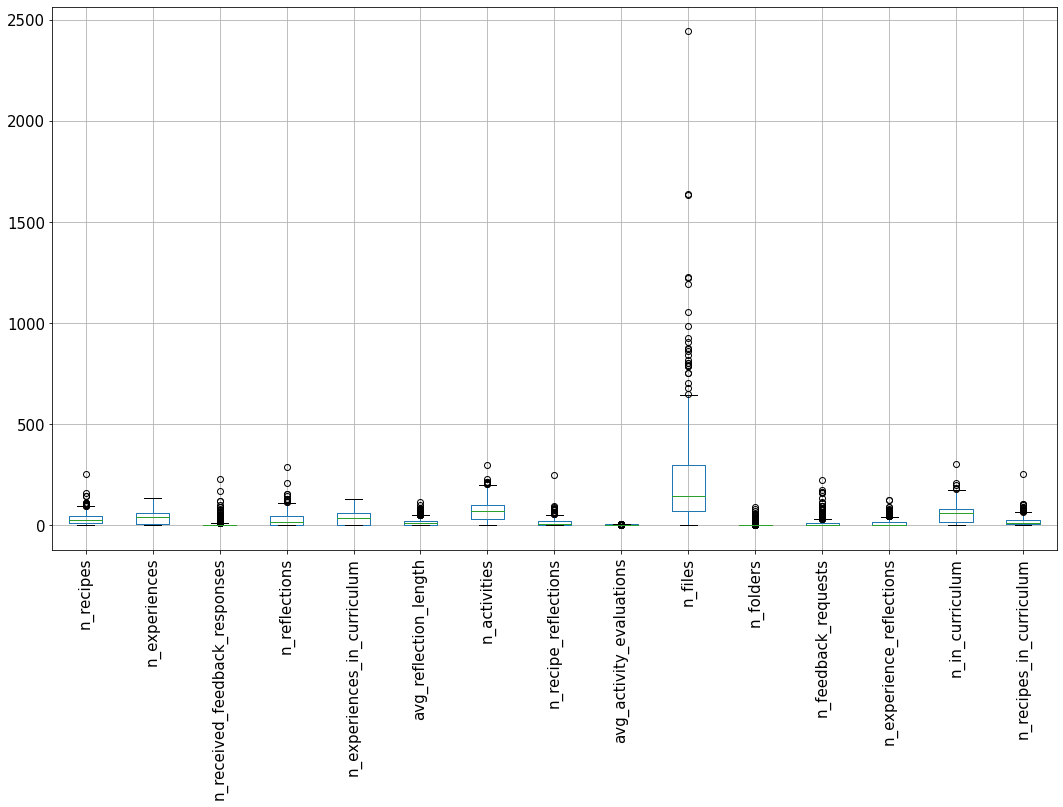

In [57]:
fig = students[features].boxplot(figsize=(18,10),grid=True, rot=90, fontsize=15)

------------
# Explore classification algorithms

In [31]:
clfs = {
    'mnb': MultinomialNB(),
    'gnb': GaussianNB(),
    'svm1': SVC(kernel='linear'),
    'svm2': SVC(kernel='rbf'),
    'svm3': SVC(kernel='sigmoid'),
    #'mlp1': MLPClassifier(),
    #'mlp2': MLPClassifier(hidden_layer_sizes=[100, 100]),
    'ada': AdaBoostClassifier(),
    'dtc': DecisionTreeClassifier(),
    'rfc': RandomForestClassifier(),
    'gbc': GradientBoostingClassifier(),
    'lr': LogisticRegression()
}

### Without PCA

In [35]:
scores_per_quatile = dict()
accuracies_per_quatile = dict()
times_per_quatile = dict()

n = 2

for perc in range(5,100,5):
    print(f'processing percentile {perc}%',end=". ")
    scores_per_quatile[perc] = dict()
    accuracies_per_quatile[perc] = dict()
    times_per_quatile[perc] = dict()
    
    q_flex = students['E_grade'].quantile(perc/100)
    students['E_result'] = np.where(students['E_grade']<q_flex, 0, 1)
    
    
    X = students[features]
    y = students['E_result']
    
    for clf_name in clfs:
        
        clf = clfs[clf_name]
        f1_scores = np.zeros(n)
        accuracy_scores = np.zeros(n)
        times = np.zeros(n)
        
        start = time.clock()
        
        for i in range(0,n):
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test
            
            # imputation
            imp = SimpleImputer(strategy="mean")
            X_train = imp.fit_transform(X_train)
            X_test  = imp.transform(X_test)

            # normalization
            scaler = MinMaxScaler()
            X_train = scaler.fit_transform(X_train)
            X_test  = scaler.transform(X_test)

            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            f1_scores[i] = f1_score(y_pred, y_test)
            accuracy_scores[i] = accuracy_score(y_pred,y_test)
            
            end = time.clock()
            times[i] = end - start
        
        scores_per_quatile[perc][clf_name] = f1_scores.mean()
        accuracies_per_quatile[perc][clf_name] = accuracy_scores.mean()
        times_per_quatile[perc][clf_name] = times.mean()
        
        
    print("OK!")

processing percentile 5%. OK!
processing percentile 10%. OK!
processing percentile 15%. OK!
processing percentile 20%. OK!
processing percentile 25%. OK!
processing percentile 30%. OK!
processing percentile 35%. OK!
processing percentile 40%. OK!
processing percentile 45%. OK!
processing percentile 50%. OK!
processing percentile 55%. OK!
processing percentile 60%. OK!
processing percentile 65%. OK!
processing percentile 70%. OK!
processing percentile 75%. OK!
processing percentile 80%. OK!
processing percentile 85%. OK!
processing percentile 90%. OK!
processing percentile 95%. OK!


In [38]:
scores_per_clf = dict()
accuracies_per_clf = dict()
times_per_clf = dict()
for clf_name in clfs:
    scores_per_clf[clf_name] = dict()
    accuracies_per_clf[clf_name] = dict()
    times_per_clf[clf_name] = dict()
    for qt in scores_per_quatile:
        scores_per_clf[clf_name][qt] = scores_per_quatile[qt][clf_name]
        accuracies_per_clf[clf_name][qt] = accuracies_per_quatile[qt][clf_name]
        times_per_clf[clf_name][qt] = times_per_quatile[qt][clf_name]

In [39]:
fig = px.line(pd.DataFrame(scores_per_clf))
fig.update_layout(
    yaxis_title="f1 score",
    xaxis_title="percentile split",
    legend_title_text='Algorithm'
)
fig.update_traces(line_traces)

fig.show()

In [41]:
fig = px.line(pd.DataFrame(accuracies_per_clf))
fig.update_layout(
    yaxis_title="Accuracy",
    xaxis_title="percentile split",
    legend_title_text='Algorithm'
)
fig.update_traces(line_traces)

fig.show()

In [42]:
fig = px.line(pd.DataFrame(times_per_clf))
fig.update_layout(
    yaxis_title="time",
    xaxis_title="percentile split",
    legend_title_text='Algorithm'
)
fig.update_traces(line_traces)

fig.show()

-----------
### With PCA

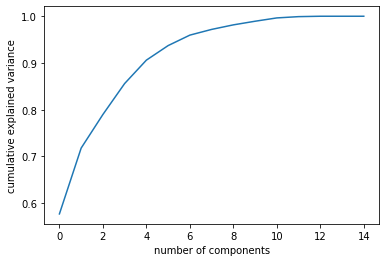

In [46]:
perc = 0.8
q_flex = students['E_grade'].quantile(perc)
students['E_result'] = np.where(students['E_grade']<q_flex, 0, 1)
X = SimpleImputer(strategy="mean").fit_transform(students[features])
y = students['E_result']

pca = PCA().fit(scaler.fit_transform(X))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

let's say 4 components

In [47]:
scores_per_quatile = dict()
accuracies_per_quatile = dict()
times_per_quatile = dict()

n = 2
n_components = 4

pca = PCA(n_components=n_components)

for perc in range(5,100,5):
    print(f'processing percentile {perc}%',end=". ")
    scores_per_quatile[perc] = dict()
    accuracies_per_quatile[perc] = dict()
    times_per_quatile[perc] = dict()
    
    q_flex = students['E_grade'].quantile(perc/100)
    students['E_result'] = np.where(students['E_grade']<q_flex, 0, 1)
    
    
    X = students[features]
    y = students['E_result']
    
    for clf_name in clfs:
        
        clf = clfs[clf_name]
        f1_scores = np.zeros(n)
        accuracy_scores = np.zeros(n)
        times = np.zeros(n)
        
        start = time.clock()
        
        for i in range(0,n):
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 
            
            # imputation
            imp = SimpleImputer(strategy="mean")
            X_train = imp.fit_transform(X_train)
            X_test  = imp.transform(X_test)

            # normalization
            scaler = MinMaxScaler()
            X_train = scaler.fit_transform(X_train)
            X_test  = scaler.transform(X_test)
            
            # PCA
            X_train = pca.fit_transform(X_train)
            X_test  = pca.transform(X_test)

            # normalization after PCA for algorithms like MNB that do not accept negative values
            scalerPCA = MinMaxScaler()
            X_train = scalerPCA.fit_transform(X_train)
            X_test  = scalerPCA.transform(X_test)

            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            f1_scores[i] = f1_score(y_pred, y_test)
            accuracy_scores[i] = accuracy_score(y_pred,y_test)
            
            end = time.clock()
            times[i] = end - start
        
        scores_per_quatile[perc][clf_name] = f1_scores.mean()
        accuracies_per_quatile[perc][clf_name] = accuracy_scores.mean()
        times_per_quatile[perc][clf_name] = times.mean()
        
        
    print("OK!")

processing percentile 5%. OK!
processing percentile 10%. OK!
processing percentile 15%. OK!
processing percentile 20%. OK!
processing percentile 25%. OK!
processing percentile 30%. OK!
processing percentile 35%. OK!
processing percentile 40%. OK!
processing percentile 45%. OK!
processing percentile 50%. OK!
processing percentile 55%. OK!
processing percentile 60%. OK!
processing percentile 65%. OK!
processing percentile 70%. OK!
processing percentile 75%. OK!
processing percentile 80%. OK!
processing percentile 85%. OK!
processing percentile 90%. OK!
processing percentile 95%. OK!


In [48]:
scores_per_clf = dict()
accuracies_per_clf = dict()
times_per_clf = dict()
for clf_name in clfs:
    scores_per_clf[clf_name] = dict()
    accuracies_per_clf[clf_name] = dict()
    times_per_clf[clf_name] = dict()
    for qt in scores_per_quatile:
        scores_per_clf[clf_name][qt] = scores_per_quatile[qt][clf_name]
        accuracies_per_clf[clf_name][qt] = accuracies_per_quatile[qt][clf_name]
        times_per_clf[clf_name][qt] = times_per_quatile[qt][clf_name]

In [49]:
fig = px.line(pd.DataFrame(scores_per_clf))
fig.update_layout(
    yaxis_title="f1 score",
    xaxis_title="percentile split",
    legend_title_text='Algorithm'
)
fig.update_traces(line_traces)

fig.show()

In [50]:
fig = px.line(pd.DataFrame(accuracies_per_clf))
fig.update_layout(
    yaxis_title="Accuracy",
    xaxis_title="percentile split",
    legend_title_text='Algorithm'
)
fig.update_traces(line_traces)

fig.show()

In [51]:
fig = px.line(pd.DataFrame(times_per_clf))
fig.update_layout(
    yaxis_title="time",
    xaxis_title="percentile split",
    legend_title_text='Algorithm'
)
fig.update_traces(line_traces)

fig.show()

-----

In [44]:
# percentile <--> grade
for perc in range(5,100,5):
    q_grade = students['E_grade'].quantile(perc/100)
    print(f'{perc}%: {round(q_grade,2)}')

5%: 3.5
10%: 4.0
15%: 4.0
20%: 4.2
25%: 4.37
30%: 4.5
35%: 4.5
40%: 4.58
45%: 4.7
50%: 4.77
55%: 4.83
60%: 4.9
65%: 5.0
70%: 5.01
75%: 5.13
80%: 5.23
85%: 5.31
90%: 5.5
95%: 5.5
